---
format:
  html:
    code-fold: true
execute:
  warning: false
---

# Commuting Numbers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"
import warnings
warnings.filterwarnings('ignore')

In [2]:
with open("../data/data.csv", "r") as f:
    df = pd.read_csv(f)
df.head()

,Level,Category,Variable,County,Date,GEOID,State FIPS,State,Value,Denominator,Denominator Description,Row-ID,Latitude,Longitude,Location,Year
0,County,Airports,Total Airports,"Grant County, Wisconsin",01/01/2020 12:00:00 AM,55043,55,Wisconsin,9.0,9.0,Total Airports,airports-2020-55043,42.867479,-90.706205,POINT (-90.706205 42.867479),2020
1,County,Airports,Total Airports,"Taylor County, Florida",01/01/2020 12:00:00 AM,12123,12,Florida,7.0,7.0,Total Airports,airports-2020-12123,30.047015,-83.603520,POINT (-83.60352 30.047015),2020
2,County,Airports,Total Airports,"Stephens County, Texas",01/01/2020 12:00:00 AM,48429,48,Texas,2.0,2.0,Total Airports,airports-2020-48429,32.735872,-98.836184,POINT (-98.836184 32.735872),2020
3,County,Airports,Other airports,"Knox County, Maine",01/01/2020 12:00:00 AM,23013,23,Maine,7.0,9.0,Total Airports,other-airports-2020-23013,44.155975,-69.234045,POINT (-69.234045 44.155975),2020
4,County,Airports,Primary Airports,"Colfax County, New Mexico",01/01/2020 12:00:00 AM,35007,35,New Mexico,0.0,5.0,Total Airports,primary-airports-2020-35007,36.606139,-104.646840,POINT (-104.64684 36.606139),2020


In [3]:
filtered_df = df[(df['Category'] == 'Person trips') & (df['Variable'] == 'Total trips')]

In [4]:
aggregated_df = df.groupby('State')['Value'].sum().reset_index()
def abbreviate_states(states):
    state_dict = {
        'Alabama': 'AL', 'Alaska': 'AK', 'American Samoa': 'AS', 'Arizona': 'AZ', 'Arkansas': 'AR',
        'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL',
        'Georgia': 'GA', 'Guam': 'GU', 'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL',
        'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA',
        'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN',
        'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
        'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC',
        'North Dakota': 'ND', 'Northern Mariana Islands': 'MP', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR',
        'Pennsylvania': 'PA', 'Puerto Rico': 'PR', 'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD',
        'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virgin Islands': 'VI',
        'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY',
        'District of Columbia': 'DC'
    }
    abbreviated_states = [state_dict[state] if state in state_dict else state for state in states]

    return abbreviated_states

aggregated_df['State'] = abbreviate_states(aggregated_df['State'])

fig = px.choropleth(
    aggregated_df,
    locations='State',
    color_continuous_scale="Viridis",
    locationmode='USA-states',
    color='Value',
    scope='usa',
    title='Choropleth Map based on State Values of Travel Frequency'
)

fig.show()

In [5]:
filtered_df = filtered_df[filtered_df['State'].isin(["California", "Texas", "New York", "Florida", "Illinois"])]

In [6]:
values=filtered_df['Value']
endpts = list(np.mgrid[min(values):max(values):150j])
fig = ff.create_choropleth(fips=filtered_df['GEOID'], binning_endpoints=endpts,values=values,  legend_title='Travel Frequency by County in the top 5 States with most Aggregated Trips')
fig.layout.template = None
fig.update_layout(
    legend_x = 0,
    annotations = {'x': -0.5, 'xanchor': 'left'}
)
fig.show()

In [7]:
top_100_values_df = filtered_df.nlargest(50, 'Value')
df_with_top100_travel = df[df['GEOID'].isin(top_100_values_df['GEOID'])]
df_with_top100_travel = df_with_top100_travel[df_with_top100_travel['Category'].isin(['Business', 'Commuting'])]
df_with_top100_travel = df_with_top100_travel[(df_with_top100_travel['Variable'] == 'Establishments') | (df_with_top100_travel['Variable'] == "Commute by car/ truck/van")]

In [8]:
pivoted_df = df_with_top100_travel.pivot_table(index='County', columns='Variable', values='Value', aggfunc='first')

In [9]:
reset_df = pivoted_df.reset_index().melt(id_vars='County', var_name='Variable', value_name='Value')
fig = px.bar(
    reset_df,
    x='County',
    y='Value',
    color='Variable',  
    barmode='group',
    title='Comparison of Commuting (Personal vehicle) vs. Business (Establishments) for the Counties with top 100 most Travel',
    labels={'Value': 'Value', 'County': 'County name'}
)

fig.update_layout(
    xaxis_title='County name',
    yaxis_title='Value',
    legend_title='Variable',
    xaxis={'categoryorder':'total ascending'}  
)

fig.show()

In [10]:
income_vs_commute = df[(df['Category'] == "Demographics") | (df['Category'] == "Commuting")]
income_vs_commute = income_vs_commute[income_vs_commute['Variable'].isin(["Median Household Income", "Commute by car/ truck/van"])]
income_vs_commute = income_vs_commute[income_vs_commute['GEOID'].isin(top_100_values_df['GEOID'])]

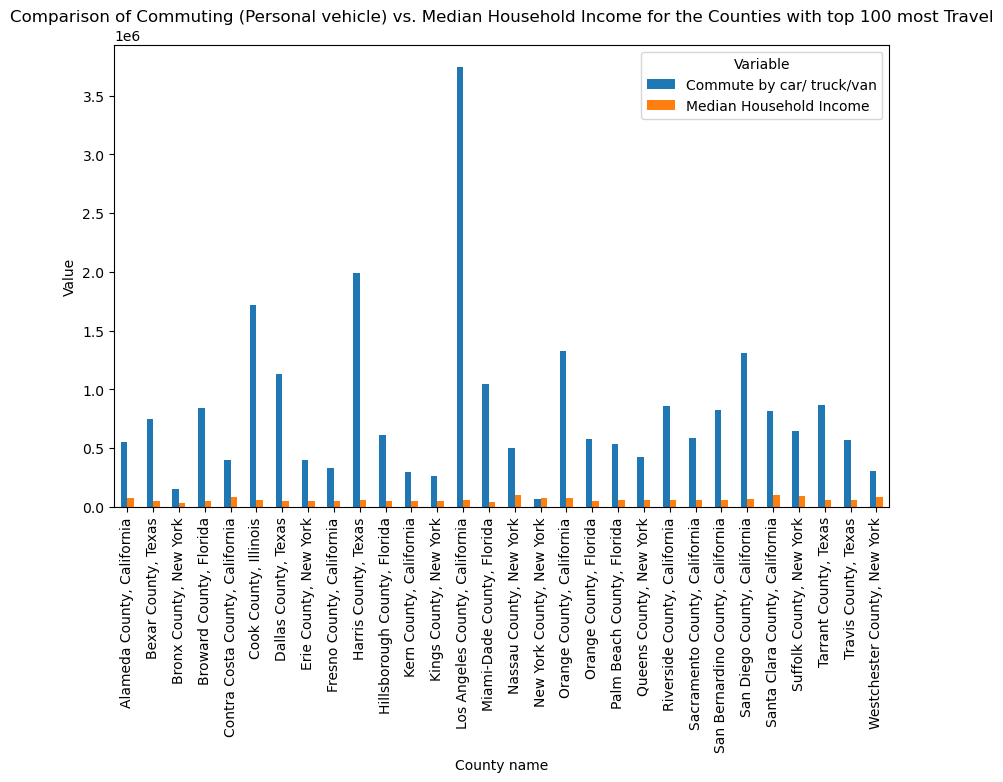

In [11]:
pivoted_df = income_vs_commute.pivot_table(index='County', columns='Variable', values='Value', aggfunc='first')
pivoted_df.plot(kind='bar', figsize=(10, 6))

plt.xlabel('County name')
plt.ylabel('Value')
plt.title('Comparison of Commuting (Personal vehicle) vs. Median Household Income for the Counties with top 100 most Travel')
plt.show()